<a href="https://colab.research.google.com/github/kumj2028/CSEN-5350-Application-of-Neural-Networks/blob/main/project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project
## Mengxiang Jiang

The majority of the code and images here comes from the [Companion Jupyter notebooks for the book "Deep Learning with Python"](https://github.com/fchollet/deep-learning-with-python-notebooks) by François Chollet, specifically chapter 12.
If the code comes from somewhere else it will have a source linked to the original.\
[Short Video Link](https://youtu.be/-LP7932s29M)\
[Long Video Link](https://youtu.be/M4aIFlE_EaA)

### Implementing a VAE with Keras
**VAE encoder network**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │      4,640 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     32,800 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         66 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         66 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,796 (264.83 KB)

 Trainable params: 67,796 (264.83 KB)

 Non-trainable params: 0 (0.00 B)

**Latent-space-sampling layer**

In [2]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**VAE decoder network, mapping latent space points to images**

In [3]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 32))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 16)   │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 1)    │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,833 (214.19 KB)

 Trainable params: 54,833 (214.19 KB)

 Non-trainable params: 0 (0.00 B)

**VAE model with custom `train_step()`**

In [4]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Processing Cats and Dogs Audio Files
Using code examples from Audio Data Processing in Python by Rob Mulla [source](https://youtu.be/ZqpSb5p1xQo)

**imports for audio**

In [5]:
import os
import numpy as np
import librosa
import IPython.display as ipd

**Playing Audio Example**

In [6]:
!git clone https://github.com/Charan-Nandarapu/Cat-and-Dog-Audio-Classification.git
!mkdir cats_dogs
!cp -r /content/Cat-and-Dog-Audio-Classification/cat/* /content/cats_dogs
!cp -r /content/Cat-and-Dog-Audio-Classification/dog_barking/* /content/cats_dogs

example = 'cats_dogs/cat_55.wav'
y, sr = librosa.load(example)
ipd.Audio(example, rate=sr)

Cloning into 'Cat-and-Dog-Audio-Classification'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 304 (delta 2), reused 0 (delta 0), pack-reused 299 (from 1)
Receiving objects: 100% (304/304), 52.50 MiB | 38.07 MiB/s, done.
Resolving deltas: 100% (14/14), done.


**Read Audio Example**

In [7]:
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-4.7695365e-13 -2.7231846e-13  6.0946902e-13 -1.0876644e-12
  1.0821471e-13 -7.5358697e-13  1.1852891e-12 -3.9097398e-13
  5.9609826e-13  7.5963156e-13]
shape y: (20360,)
sr: 22050


**Plot of Audio File**

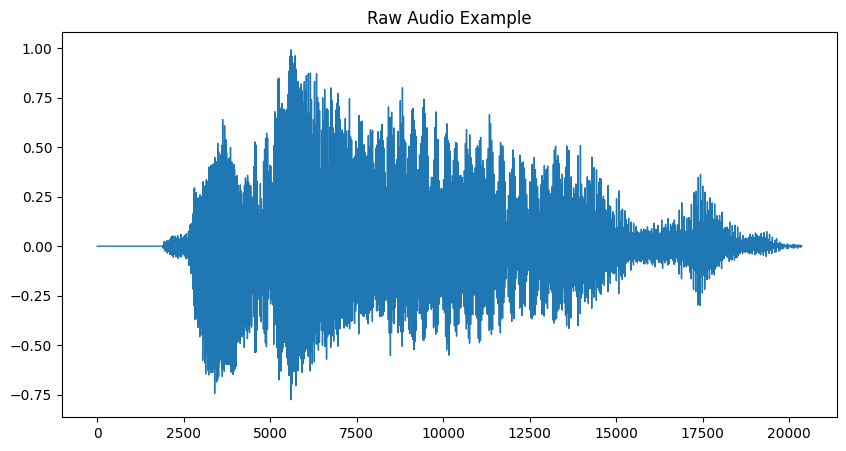

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                  color=color_pal[0])
plt.show()

**Plot of Trimmed Audio File**

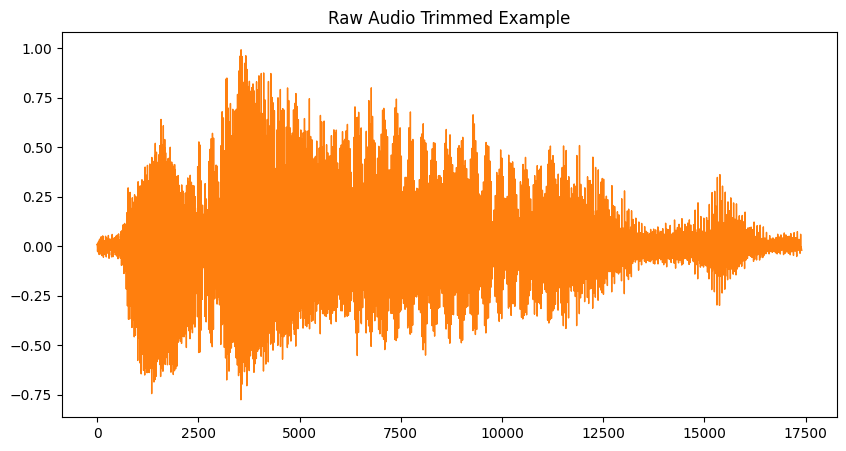

In [9]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                  color=color_pal[1])
plt.show()

In [10]:
y_truncated = y_trimmed[:8157]
D = librosa.stft(y_truncated, n_fft=256)[:128]
print(D)

[[-1.5450765e-01+0.0000000e+00j -1.2125368e-01+0.0000000e+00j
  -2.5592126e-02+0.0000000e+00j ... -5.5398576e-02+0.0000000e+00j
  -9.5129628e-03+0.0000000e+00j  5.5073276e-02+0.0000000e+00j]
 [ 1.5119709e-01-3.3558540e-02j  3.9501935e-02+6.8126164e-02j
   1.9317612e-02+2.7503161e-02j ...  6.7590117e-02-1.1957300e-02j
  -8.6155636e-03+5.3830512e-02j -3.7132040e-02+7.5932462e-03j]
 [-1.3415165e-01+5.3168114e-02j  9.2390053e-02-8.1454897e-03j
  -1.0553519e-02-3.6753919e-02j ... -7.6347515e-02+9.1338065e-03j
   2.5777645e-02-2.9614935e-02j -7.7043902e-03-3.3790688e-03j]
 ...
 [-3.3752809e-03+4.7797483e-05j -2.2966644e-05-1.6797942e-03j
   4.4584763e-07-1.0675447e-07j ... -1.2628220e-06+9.7183272e-07j
   2.7232640e-03+1.6214006e-03j -8.0602774e-03+1.3595354e-02j]
 [ 3.3769177e-03-3.2050473e-05j -1.6809161e-03+1.5288759e-05j
   4.2058605e-07-8.4614648e-08j ... -1.5176213e-06+1.3024639e-06j
   5.1871908e-04+3.1291379e-03j -2.6195773e-03-1.5580659e-02j]
 [-3.3784988e-03+1.6054504e-05j  7.39804

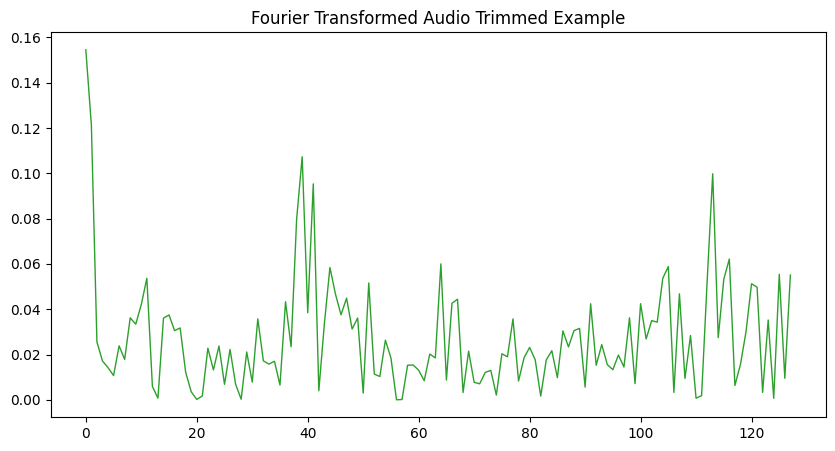

In [11]:
pd.Series(np.abs(D)[0]).plot(figsize=(10, 5),
                  lw=1,
                  title='Fourier Transformed Audio Trimmed Example',
                  color=color_pal[2])
plt.show()

In [12]:
y_hat = librosa.istft(np.abs(D))
print(y_hat.shape)
ipd.Audio(y_hat, rate=sr)

(8001,)


In [13]:
y_hat = librosa.griffinlim(np.abs(D))
print(y_hat.shape)
ipd.Audio(y_hat, rate=sr)

(8001,)


**create STFT data**

In [14]:
SOUND_FILES = 'cats_dogs/'
stft_data = []
for sound in os.listdir(SOUND_FILES):
    x, sr = librosa.load(SOUND_FILES + sound)
    x_trimmed, _ = librosa.effects.trim(x, top_db=20)
    # truncate to only 0.37 seconds (8157 samples)
    x_trimmed_truncated1 = x_trimmed[:8157]
    #x_trimmed_truncated2 = x_trimmed[-8157:]
    X1 = librosa.stft(x_trimmed_truncated1, n_fft=256)[:128]
    #X2 = librosa.stft(x_trimmed_truncated2, n_fft=256)[:128]
    stft_data.append(np.abs(X1))
    #stft_data.append(np.abs(X2))



In [15]:
stft_data = np.array(stft_data)
print(stft_data.shape)
stft_min = np.min(stft_data)
stft_max = np.max(stft_data)
print(stft_max)
stft_data = np.expand_dims(stft_data, -1).astype("float32")
stft_data = (stft_data-stft_min)/(stft_max-stft_min)
print(stft_data.shape)
np.random.shuffle(stft_data)


(277, 128, 128)
113.416275
(277, 128, 128, 1)


**Training the VAE**

In [16]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(stft_data, epochs=1000)

Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 558ms/step - kl_loss: 5.4189e-04 - reconstruction_loss: 11263.2959 - total_loss: 11263.2969
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 0.8316 - reconstruction_loss: 10345.9150 - total_loss: 10346.9023
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - kl_loss: 645.9746 - reconstruction_loss: 2318.3921 - total_loss: 2960.8872
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - kl_loss: 19.8871 - reconstruction_loss: 929.1344 - total_loss: 948.9551
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - kl_loss: 4.5424 - reconstruction_loss: 737.6458 - total_loss: 742.1730
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - kl_loss: 0.8911 - reconstruction_loss: 600.0518 - total_loss: 600.9406
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - kl_loss: 0.3141 - reconstruction_loss: 528.6109 - total_loss: 528.9244
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - kl_loss: 0.1527 - reconstruction_loss: 522.4960 - total_loss

**Sampling a grid of sounds from the 2D latent space**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


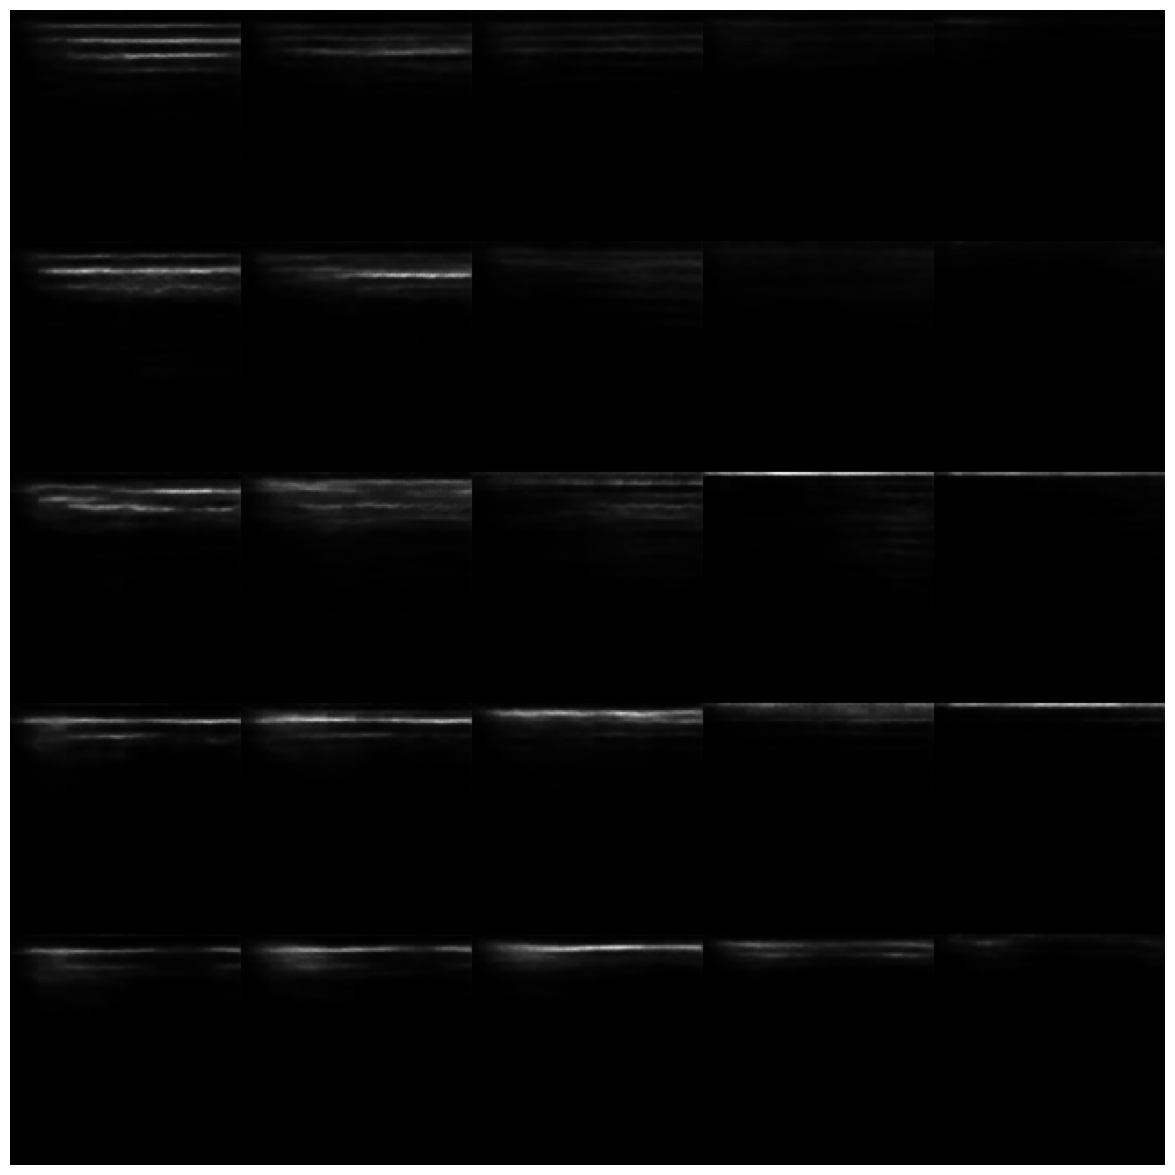

In [17]:
import matplotlib.pyplot as plt

n = 5
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

**Sampling a random sound from the 2D latent space**

In [27]:
import soundfile as sf
import random

z_sample = np.array([[random.uniform(-1, 1), random.uniform(-1, 1)]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [19]:
z_sample = np.array([[-1, -1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


In [20]:
z_sample = np.array([[-1, 1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [21]:
z_sample = np.array([[1, -1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [22]:
z_sample = np.array([[1, 1]])
x_decoded = vae.decoder.predict(z_sample)
x_decoded = x_decoded.reshape(128, 128)
x_decoded = x_decoded*(stft_max-stft_min)+stft_min
X = librosa.griffinlim(x_decoded)
ipd.Audio(X, rate=sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
